<a href="https://colab.research.google.com/github/tp92-chaudhary/my-work-/blob/master/stabledefusion_using_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>A stable dufissiun using <b>huggingface diffuser</b>(concepts-library) </h1>

## Initial setup

<h2>Install the required libs<h2>

In [ ]:
# Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00


<h2>Install xformers for faster and memory efficient training(for low end GPU)<h2>

In [ ]:

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try: 
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
  
elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 MB 8.1 MB/s eta 0:00:00


<h2>Enviroment Setup</h2>

In [ ]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Need to compile C++ extensions to get sparse attention support. Please run python setup.py build develop


/usr/local/lib/python3.8/dist-packages/xformers/_C.so: undefined symbol: _ZNK3c104impl13OperatorEntry20reportSignatureErrorENS0_12CppSignatureE


<h2>getting model </h2>

In [ ]:

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
# #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}




<h2>adding data set using urls</h2>

In [ ]:
urls = [
      
"https://p4.wallpaperbetter.com/wallpaper/990/374/475/jinx-league-of-legends-arcane-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/597/595/773/arcane-jinx-league-of-legends-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/455/986/460/jinx-league-of-legends-arcane-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/769/667/606/jinx-league-of-legends-arcane-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/836/342/438/jinx-league-of-legends-vi-league-of-legends-arcane-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/211/1017/269/cyberpunk-edgerunners-cyberpunk-2077-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/8/868/36/cyberpunk-edgerunners-cyberpunk-2077-lucy-edgerunners-rebecca-edgerunners-hd-wallpaper-preview.jpg",
"https://p4.wallpaperbetter.com/wallpaper/288/722/467/cyberpunk-edgerunners-lucy-edgerunners-anime-girls-cyberpunk-2077-cyberpunk-hd-wallpaper-preview.jpg",
      
      ]

<h2>Checking if immages are loaded</h2>

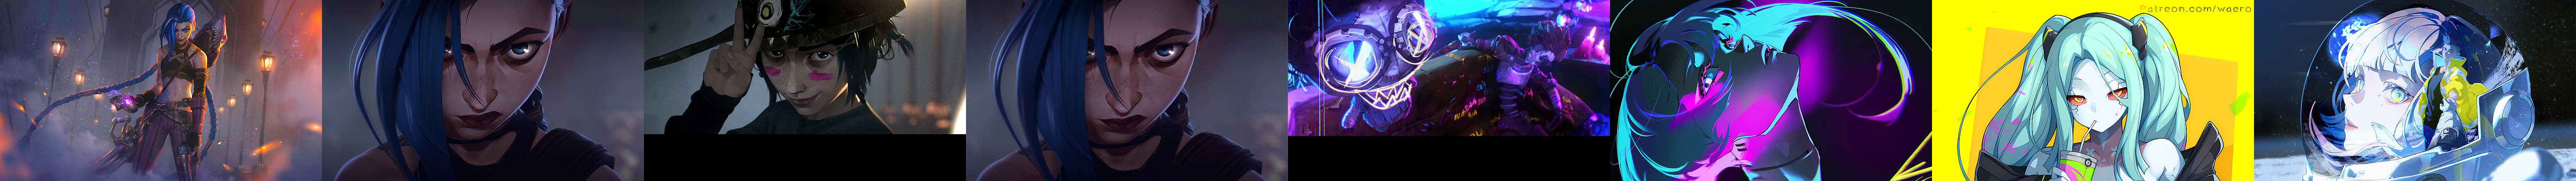

In [ ]:
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

<h2>innitilizing placeholder and initial token for newly created concept</h2>

In [ ]:
what_to_teach = "object" 

placeholder_token = "\u003Canime-style>" 

#tokeniser spellings always check(token dana sa phla confrm ke lana)
initializer_token = "character" #character mean k art ma chracter banana ha 

<h2>setting peompts for traning

In [ ]:

imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
    "4k",
    "hyeper realistic",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
    "lying on rose bed of {}",
]

<h2>setting dataset

In [ ]:

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

<h2>Load the tokenizer and add the placeholder token as a additional special token.

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

<h2> Get token ids for our placeholder and initializer token. This code 

In [ ]:

# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

<h2>Load the Stable Diffusion model

In [ ]:

# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

<h2>added the "placeholder_token" in the "tokenizer" so we resize the token embeddings<h2>
<h2>create a new embedding vector in the token embeddings

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

<h2>Initialise the newly added placeholder token

In [ ]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

<h2>train the newly added embedding vecto

In [ ]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

<h2>Creating training data

In [ ]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)



In [ ]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [ ]:

    #creating noise secdular
    noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

<h2>Setting traning arguments

In [ ]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

<h2>traninfg functions

In [ ]:
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()

    
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

<h2>launching traning on gpu(will not work without gpu)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

<h2>set up pipeline

In [ ]:
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")